In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ctypes import *
file = "./testing.so"
my_func = CDLL(file)

In [2]:
size = 400
L = 10.0
dt = 0.002
bigT = 40000

G = 0.0
a = 0.0
k = 1.0

In [3]:
x = np.linspace(-L,L,size)
dx = x[1]-x[0]
T = np.zeros((size,size))
T2 = np.zeros((size,size))
V = np.zeros((size,size))
Q = np.zeros((size,size))
V2Grav = np.zeros((size,size))
I = np.identity(size)
I = I.astype(complex)
psi = np.zeros((size))

phi = -np.exp(-x*x/2.0)/100.0
phi[0] = 0.0
phi[size-1] = 0.0

In [4]:
def setupPsi():
    global psi
    psi = np.exp(-x*x/2.0)
    normalization = np.trapz(2.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x)
    psi = psi/normalization

    for index, value in enumerate(psi):
        if(value<1e-10):
            psi[index] = 0
    psi = psi.astype(complex)

def setupT():
    global T, T2
    for i in range(size):
        T[i][i] = -2.0
        if(i!=size-1):
            T[i][i+1] = 1.0
            T2[i][i+1] = 1.0/2.0/x[i]
        if(i!=0):
            T[i][i-1] = 1.0
            T2[i][i-1] = -1.0/2.0/x[i]

    T = -1.0/2.0/dx/dx*T
    T2 = -1.0/dx*T2
    T = T.astype(complex)
    T2 = T2.astype(complex)
        

def setupV():
    global V
    for i in range(size):
        V[i][i] = 1.0/2.0*k*x[i]*x[i]
    V = V.astype(complex)

def setupQ():
    global Q
    for i in range(size):
        Q[i][i] = 4.0*np.pi*a*np.absolute(psi[i])*np.absolute(psi[i])

    Q = Q.astype(complex)

def setupV2Grav():
    global V2Grav, phi, psi

    rho = np.absolute(psi)[size//2:]*np.absolute(psi)[size//2:]
    rho_c = (c_double * size)(*rho)
    phi_c = (c_double * size)(*np.absolute(phi)[size//2:])
    my_func.findGravRho(rho_c, phi_c, c_int(size//2), c_double(dx))
    for i in range(size//2):
        place = int(size//2 + i)
        phi[place] = phi_c[i] * G

    for i in range(size//2):
        V2Grav[i][i] = phi[size-i-1]
        V2Grav[size-i-1][size-i-1] = phi[size-i-1]
            
        phi[i] = phi[size-i-1] #Regulate

In [5]:
setupPsi()
setupT()
setupV()
setupQ()
setupV2Grav()

In [6]:
def setupU1U2():
    global U1
    global U2
    U1 = I + 1.0j*dt/2.0*(T+T2+V+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0*(T+T2+V+Q+V2Grav)

0.0 0.17953072834505243
0.002 0.17953080184904174
0.004 0.1795310223485311
0.006 0.17953138981116734
0.008 0.17953190419106096
0.01 0.17953256542452106
0.012 0.17953337342062545
0.014 0.17953432806179395
0.016 0.1795354292148824
0.018000000000000002 0.17953667673608717
0.02 0.17953807046097248
0.022 0.17953961019363193
0.024 0.179541295711686
0.026000000000000002 0.17954312678086878
0.028 0.17954510315820096
0.03 0.17954722457907635
0.032 0.17954949074737744
0.034 0.17955190134339089
0.036000000000000004 0.17955445603791226
0.038 0.17955715449182882
0.04 0.17955999634224643
0.042 0.17956298119624617
0.044 0.1795661086416906
0.046 0.17956937825891714
0.048 0.1795727896161184
0.05 0.17957634225594726
0.052000000000000005 0.17958003569391034
0.054 0.17958386943104268
0.056 0.17958784296186026
0.058 0.1795919557660654
0.06 0.17959620729718098
0.062 0.1796005969856761
0.064 0.1796051242519543
0.066 0.17960978850977544
0.068 0.17961458915551703
0.07 0.1796195255601953
0.07200000000000001 0.1

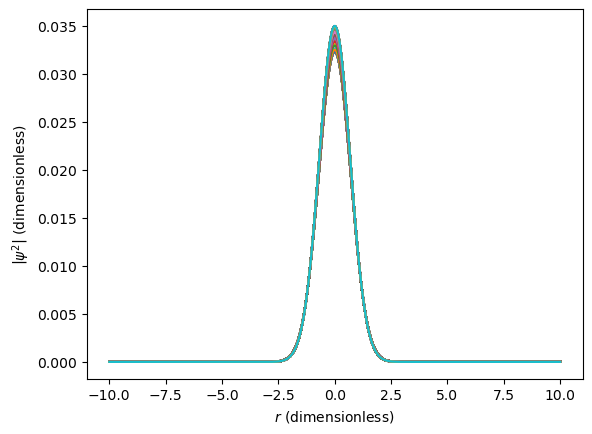

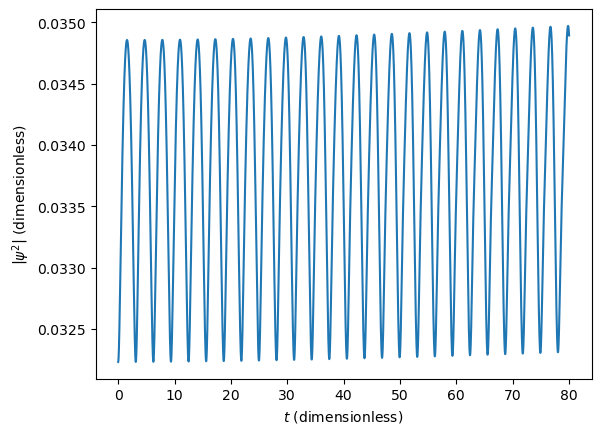

In [7]:
setupU1U2()
hello = []
ts = []
for t in range(bigT):

    print(t*dt, np.absolute(psi[size//2]))
    hello.append(np.absolute(psi[size//2])*np.absolute(psi[size//2]))
    ts.append(t*dt)
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    setupQ()
    setupV()
    setupV2Grav()
    setupU1U2()

    if t%100 == 0:
        plt.plot(x, np.absolute(psi)*np.absolute(psi))

plt.xlabel(r"$r$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

plt.plot(ts, hello)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

0.0125
0.325 18.996409493279604
0.6375000000000001 3.155460349771141
0.9625 1.2036222455996404


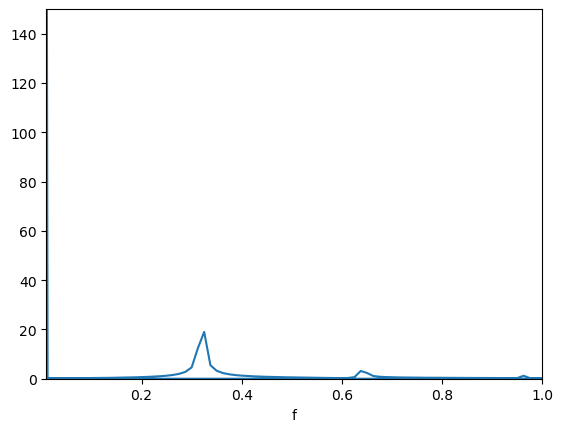

In [8]:
sp = np.fft.fft(hello)
freq = np.fft.fftfreq(len(hello), d=dt)

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,1.0)
plt.ylim(0.0,150.0)
plt.xlabel("f")

print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 1.0 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))